In [1]:
# extract, re-rebase and plot
# used to compare singles using 15-yr MA vs 30-yr MA, 30-yr bartlett long run loggdppc
import xarray as xr
import numpy as np
import pandas as pd
import getpass
import sys
import os
import pathlib
import time
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
username = getpass.getuser()


/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
def rebase_combine(file):
    dt = xr.open_dataset(file)
    # select years & columns needed for rebasing
#     pdb()
    base = (dt.sel(
            {"year": slice(2001,2010)}
            )
            [['regions','highriskimpacts', 'lowriskimpacts']]
           )
    # subtract off mean of base years -> rebasing!
    mean_base = base.mean(dim="year")
    rebased = dt - mean_base
    # calculate combined, rebased impact
    rebased['rebased_new'] = rebased.highriskimpacts * dt['clip'] + rebased.lowriskimpacts * (1 - dt['clip'])
    # add back onto dataframe
    # print(rebased.head())
    dt['rebased_new'] = rebased['rebased_new']    
    dt.rebased_new.attrs = { 'long_title' : 'Rebased sum of results weighted on fractions of unity',
    'units' : 'minutes worked by individual',
    'source' : 'calculated as rebased_new = minlost_hi_rebased * riskshare_hi + minlost_lo_rebased * (1 - riskshare_hi)'}
    return dt

# rebasing function

In [9]:
# rebase a directory
proj_root = "/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett_copy/rcp85/CCSM4/high/SSP3/"
output_root = "/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett/rcp85/CCSM4/high/SSP3/"
paths = list(pathlib.Path(proj_root).rglob('*.nc4'))

for file in paths:
    start = time.time()
    ds = rebase_combine(file)
    end = time.time()
    print(end - start)
    
    start = time.time()
    output = pathlib.Path(str(file).replace(proj_root, output_root))

    output_path = pathlib.Path(output)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    end = time.time()
    print(end - start)
    
    start = time.time() 
    ds.to_netcdf(output)
    end = time.time()
    print(end - start)
    
    print(output)



0.08281660079956055
0.0007317066192626953
0.3671858310699463
/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett/rcp85/CCSM4/high/SSP3/uninteracted_main_model_test_bartlett-noadapt.nc4
0.06219124794006348
0.0006010532379150391
0.3570892810821533
/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett/rcp85/CCSM4/high/SSP3/uninteracted_main_model_test_bartlett-histclim.nc4
0.07551312446594238
0.0008575916290283203
0.40134239196777344
/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett/rcp85/CCSM4/high/SSP3/uninteracted_main_model_test_bartlett-incadapt.nc4
0.0671229362487793
0.0006282329559326172
0.39791393280029297
/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett/rcp85/CCSM4/high/SSP3/uninteracted_main_model_test_bartlett.nc4


In [22]:
# plot all the adaptation scenarios of a single (after manual re-rebasing)
proj_root = "/shares/gcp/outputs/labor/impacts-woodwork/test_rcc_copy1/uninteracted_splines_27_37_39_by_risk_empshare_noFE_YearlyAverageDay/rcp85/CCSM4/high/SSP3/"
basename = "uninteracted_main_model"

def plot_single(proj_root, basename):
    df = pd.DataFrame()
    for adapt in ["histclim","fulladapt","incadapt","noadapt"]:
        if adapt == "fulladapt" :
            infix = ""
        else:
            infix = "-" + adapt     
        nc4 = xr.open_dataset(proj_root + basename + infix + "-pop-aggregated.nc4").to_dataframe().reset_index()
        df[adapt] = nc4['rebased_new']
        df[adapt+"_wrong_rebasing"] = nc4["rebased"]
        if adapt == "fulladapt": 
            df["year"] = nc4["year"]
            df["regions"] = nc4["regions"]
        if adapt == "fulladapt" or adapt == "incadapt":
            df[adapt] = df[adapt] - df["histclim"]
            df[adapt+"_wrong_rebasing"] = df[adapt+"_wrong_rebasing"] - df["histclim_wrong_rebasing"]

    df_plot = df[df.regions == ""]
    df_plot.plot(x = "year", y=["histclim","fulladapt","incadapt","noadapt"])
    return df_plot
    

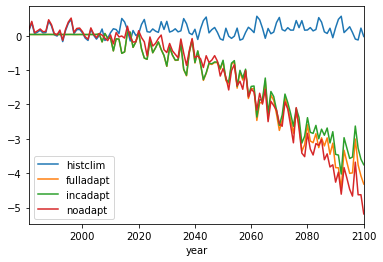

In [23]:
df_30yr = plot_single(proj_root, basename)

histclim  histclim_wrong_rebasing  fulladapt  fulladapt_wrong_rebasing  \
0    0.147390                 0.147390   0.038319                  0.038319   
1    0.381361                 0.381361   0.039299                  0.039299   
2    0.055262                 0.055262   0.038095                  0.038095   
3    0.104762                 0.104762   0.038288                  0.038288   
4    0.161017                 0.161017   0.038690                  0.038690   
..        ...                      ...        ...                       ...   
115  0.095841                -3.476347  -4.033215                 -3.262763   
116 -0.095556                -3.698013  -3.042127                 -2.255310   
117 -0.122531                -3.750705  -3.802076                 -3.016078   
118  0.223703                -3.427868  -4.118299                 -3.326010   
119 -0.020128                -3.714334  -4.361617                 -3.550251   

     year regions  incadapt  incadapt_wrong_rebasing   noadapt  \
0    1981          0.038319                 0.038319  0.185709   
1    1982          0.039299                 0.039299  0.420660   
2    1983          0.038095                 0.038095  0.093357   
3    1984          0.038288                 0.038288  0.143050   
4    1985          0.038690                 0.038690  0.199707   
..    ...     ...       ...                      ...       ...   
115  2096         -3.546772                -3.503691 -4.684535   
116  2097         -2.641517                -2.600181 -3.692370   
117  2098         -3.292268                -3.256967 -4.645553   
118  2099         -3.610140                -3.582955 -4.644015   
119  2100         -3.773630                -3.747522 -5.205098   

     noadapt_wrong_rebasing  
0                  0.185709  
1                  0.420660  
2                  0.093357  
3                  0.143050  
4                  0.199707  
..                      ...  
115               -4.684535  
116               -3.692370  
117               -4.645553  
118               -4.644015  
119               -5.205098  

[120 rows x 10 columns]

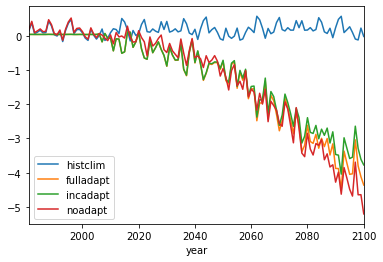

In [27]:
proj_root = "/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_bartlett/rcp85/CCSM4/high/SSP3/"
basename = "uninteracted_main_model_test_bartlett"
plot_single(proj_root, basename)

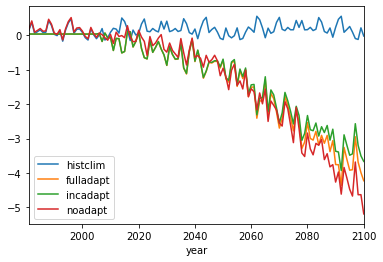

In [24]:
proj_root = "/shares/gcp/outputs/labor/impacts-woodwork/uninteracted_splines_27_37_39_by_risk_empshare_noFE_test_15yr_income/rcp85/CCSM4/high/SSP3/"
basename = "uninteracted_main_model_test_15yr_income"
df_15yr = plot_single(proj_root, basename)

In [25]:
df_30yr

histclim  histclim_wrong_rebasing  fulladapt  fulladapt_wrong_rebasing  \
0    0.147154                 0.147154   0.037369                  0.037369   
1    0.380971                 0.380971   0.037876                  0.037876   
2    0.054941                 0.054941   0.037250                  0.037250   
3    0.104432                 0.104432   0.037334                  0.037334   
4    0.160630                 0.160630   0.037521                  0.037521   
..        ...                      ...        ...                       ...   
115  0.095792                -3.474616  -3.991398                 -3.273863   
116 -0.095525                -3.697025  -3.006859                 -2.276095   
117 -0.122293                -3.753866  -3.761101                 -3.022441   
118  0.223024                -3.436092  -4.076976                 -3.327451   
119 -0.020211                -3.721640  -4.316272                 -3.547174   

     year regions  incadapt  incadapt_wrong_rebasing   noadapt  \
0    1981          0.037369                 0.037369  0.184523   
1    1982          0.037876                 0.037876  0.418847   
2    1983          0.037250                 0.037250  0.092191   
3    1984          0.037334                 0.037334  0.141765   
4    1985          0.037521                 0.037521  0.198151   
..    ...     ...       ...                      ...       ...   
115  2096         -3.530336                -3.489402 -4.668433   
116  2097         -2.628163                -2.588149 -3.679210   
117  2098         -3.275282                -3.236958 -4.628629   
118  2099         -3.593249                -3.558896 -4.628160   
119  2100         -3.754520                -3.721570 -5.186406   

     noadapt_wrong_rebasing  
0                  0.184523  
1                  0.418847  
2                  0.092191  
3                  0.141765  
4                  0.198151  
..                      ...  
115               -4.668433  
116               -3.679210  
117               -4.628629  
118               -4.628160  
119               -5.186406  

[120 rows x 10 columns]

In [26]:
df_15yr

histclim  histclim_wrong_rebasing  fulladapt  fulladapt_wrong_rebasing  \
0    0.147154                 0.147154   0.037369                  0.037369   
1    0.380971                 0.380971   0.037876                  0.037876   
2    0.054941                 0.054941   0.037250                  0.037250   
3    0.104432                 0.104432   0.037334                  0.037334   
4    0.160630                 0.160630   0.037521                  0.037521   
..        ...                      ...        ...                       ...   
115  0.093458                -3.718263  -3.903091                 -3.185068   
116 -0.092715                -3.933294  -2.944833                 -2.213548   
117 -0.119342                -3.987788  -3.681977                 -2.942772   
118  0.217601                -3.676227  -3.984180                 -3.234077   
119 -0.019897                -3.955961  -4.223166                 -3.453439   

     year regions  incadapt  incadapt_wrong_rebasing   noadapt  \
0    1981          0.037369                 0.037369  0.184523   
1    1982          0.037876                 0.037876  0.418847   
2    1983          0.037250                 0.037250  0.092191   
3    1984          0.037334                 0.037334  0.141765   
4    1985          0.037521                 0.037521  0.198151   
..    ...     ...       ...                      ...       ...   
115  2096         -3.441959                -3.400688 -4.668433   
116  2097         -2.566057                -2.525723 -3.679210   
117  2098         -3.196071                -3.157443 -4.628629   
118  2099         -3.500352                -3.465687 -4.628160   
119  2100         -3.661307                -3.628040 -5.186406   

     noadapt_wrong_rebasing  
0                  0.184523  
1                  0.418847  
2                  0.092191  
3                  0.141765  
4                  0.198151  
..                      ...  
115               -4.668433  
116               -3.679210  
117               -4.628629  
118               -4.628160  
119               -5.186406  

[120 rows x 10 columns]